## 텍스트 분류 - 네이버 영화 리뷰 분류 (긍정, 부정; 이진분류)

In [1]:
# 사용 모듈 import 할게요.
import numpy as np
import matplotlib.pyplot as plt

# 전처리를 위한 konlpy의 Okt import 할게요.
from konlpy.tag import Okt

# 임베딩을 위한 gensim import 할게요.
import gensim

# tensorflow.kears 쪽 모듈 import 할게요.
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

In [2]:
# 네이버 영화 리뷰 데이터 읽어올게요.
data_path = '../data/nsmc-master/'
lines = open(data_path+'ratings_train.txt', 'r', encoding='utf-8').readlines()

# 데이터 개수 확인할게요.
print(len(lines))

## 너무 오래 걸려서 데이터수 반으로 줄일게요.
## 데이터 열어보시면, 첫 번째 줄은 
## 데이터의 레이블이기 때문에 slicing으로 넘어갈게요.
lines = lines[1 : int(np.ceil(len(lines)*0.5))] 
print(len(lines))

150001
75000


In [3]:
# 학습 7, 평가 3 으로 데이터 나눌게요.
train_dict = {}
test_dict = {}
for idx, line in enumerate(lines):
    # 네이버 영화 리뷰 데이터는 ',' 대신 '\t'(tap)으로 
    # 나눠져 있어서, '\t'로 나눠 줄게요.
    _id, sentence, label = line.strip().split('\t')
    
    # 이 데이터는 긍정, 부정이 적절히 섞여있어서
    # 그냥 길이에 0.7 곱해서 앞쪽 70%를 학습에
    # 뒤쪽 30%를 테스트에 사용할게요.
    if idx < int(len(lines)*0.7):
        train_dict[sentence] = label
    else:
        test_dict[sentence] = label

In [4]:
# 제거할 품사 설정해 줄게요.
stop_pos = ['Punctuation', 'Hashtag', 'Foreign', 'URL', 'Email', 'Number', 'ScreenName', 'Alpha']

In [5]:
# 조금 오래걸려요.

# 학습 문장으로 words_set 생성, 업데이트하면서
# 학습 문장의 최대 길이 설정할게요.
okt = Okt()
words_set = set()
max_len_train = 0
max_len_train_idx = 0

# 먼저 train에서 데이터 받아올게요.
for idx, train_sentence in enumerate(train_dict.keys()):
    sentence = train_sentence.strip()
    
    # 분류라서 문장이 사람에게 익숙하지 않아도 되니까,
    # normalize랑 stemming 진행해 줄게요.
    words = okt.pos(sentence, norm=True, stem=True)
    
    # 토크나이즈된 문장에서
    # 제거할 품사에 해당하는 단어지우고 사용할게요.
    words = [word for word, pos in words if pos not in stop_pos ]

    # 학습 문장의 최대길이 찾아 줄게요.
    if len(words) > max_len_train:
        max_len_train = len(words)
        max_len_train_idx = idx
    
    # words_set 업데이트 할게요.
    words_set.update(words)

In [6]:
# 조금 오래걸려요.

# 테스트 문장으로도 words_set 업데이트하면서
# 테스트 문장의 최대 길이 설정할게요.
max_len_test = 0
max_len_test_idx = 0

# test에서 데이터 받아올게요.
for idx, test_sentence in enumerate(test_dict.keys()):
    sentence = test_sentence.strip()
    
    # 분류라서 문장이 사람에게 익숙하지 않아도 되니까,
    # normalize랑 stemming 진행해 줄게요.
    words = okt.pos(sentence, norm=True, stem=True)
    
    # 토크나이즈된 문장에서
    # 제거할 품사에 해당하는 단어지우고 사용할게요.
    words = [word for word, pos in words if pos not in stop_pos ]

    # 테스트 문장의 최대길이 찾아 줄게요.
    if len(words) > max_len_test:
        max_len_test = len(words)
        max_len_test_idx = idx
    
    # words_set 업데이트 할게요.
    words_set.update(words)

In [7]:
# 전체 문장에서 최대길이 찾아 줄게요.
max_len = max(max_len_train, max_len_test)
print(max_len)

# 학슴 및 테스트 데이터에서
# 각각의 최대길이 문장 확인해 볼게요.
print(max_len_train_idx)
print(max_len_test_idx)
print(list(train_dict.keys())[max_len_train_idx], '\n')
print(list(test_dict.keys())[max_len_test_idx])

76
33164
11147
사람들평점왜그러냐.이건진짜대박이다.다들 순간적인재미만느끼려고영화를보나.인생에 좀철학을생각해라.딱봐도대충사는생각없는 인간들이겉으로연출만봐서난해하다고하는 놈들그메세지가뭘표현하려고했는지성찰해라.요즘화려한그래픽이랑주연만하는그런영화들이랑 급이다르다.제대로봐라 

완전재밋게봅니당잉여공주몰랏을땐그려러니햇는데송재림때문에봣엇는데캐릭터들도좋앗구안봣으면내가후회햇을만한작품??이작품이나왓을때내가왜안봣는지모르겟다취업준비생역할의마음을잘헤아려서이시대의취준생을잘표현한것같다어쨋든송재림나와서완전조앗음♥♥♥다음에도이런작품이나왓으면!!!


In [8]:
# 테스트 데이터의 최대길이 문장,
# 토크나이즈 어떻게 되는지 확인해볼게요.
text = '완전재밋게봅니당잉여공주몰랏을땐그려러니햇는데송재림때문에봣엇는데캐릭터들도좋앗구안봣으면내가후회햇을만한작품??이작품이나왓을때내가왜안봣는지모르겟다취업준비생역할의마음을잘헤아려서이시대의취준생을잘표현한것같다어쨋든송재림나와서완전조앗음♥♥♥다음에도이런작품이나왓으면!!!'
words = okt.pos(text, norm=True, stem=True)
print([word for word, _ in words])
print([word for word, pos in words if pos not in stop_pos])

['완전', '재밌다', '보다', '잉여', '공주', '몰다', '랏', '을', '땐', '그리다', '햇', '늘다', '송재림', '때문', '에', '봣', '엇', '늘다', '캐릭터', '들', '도', '좋다', '구안', '봣으', '면', '내', '가후', '회햇', '을', '만', '한', '작품', '??', '이', '작품', '이나', '왓', '을', '때', '내', '가왜', '안봣', '늘다', '모르다', '취업', '준비', '생', '역할', '의', '마음', '을', '자다', '헤아리다', '이', '시대', '의', '취준생', '을', '자다', '표현', '한', '것', '같다', '쨋', '든', '송재림', '나오다', '완전', '조', '앗다', '♥♥♥', '다음', '에도', '이런', '작품', '이나', '왓으', '면', '!!!']
['완전', '재밌다', '보다', '잉여', '공주', '몰다', '랏', '을', '땐', '그리다', '햇', '늘다', '송재림', '때문', '에', '봣', '엇', '늘다', '캐릭터', '들', '도', '좋다', '구안', '봣으', '면', '내', '가후', '회햇', '을', '만', '한', '작품', '이', '작품', '이나', '왓', '을', '때', '내', '가왜', '안봣', '늘다', '모르다', '취업', '준비', '생', '역할', '의', '마음', '을', '자다', '헤아리다', '이', '시대', '의', '취준생', '을', '자다', '표현', '한', '것', '같다', '쨋', '든', '송재림', '나오다', '완전', '조', '앗다', '다음', '에도', '이런', '작품', '이나', '왓으', '면']


In [9]:
# words_set 길이랑 데이터 확인할게요.
words_set = list(sorted(words_set))

# zero-padding을 위해서 0번 자리에 '' 공백 하나 넣어줄게요.
words_set.insert(0, '')

print(len(words_set))
print(words_set[:10])
print(words_set[-10:])

31080
['', 'ㄱ', 'ㄱㄱ', 'ㄱㄱㄱ', 'ㄱㄴㄴㄴ', 'ㄱㄴㄷ', 'ㄱㅅ', 'ㄱㅆㄹ', 'ㄱㅇㅅ', 'ㄱㅈㄱ']
['힙', '힙자', '힙조', '힙팝', '힙합', '힙힙', '힛', '힛걸', '힝', '힝힝']


In [10]:
# 모델을 위한 형태로 
# 문장을 변경하는 함수 작성할게요.

def make_shape4model(sentence_label_dict):
    # 단어 임베딩을 위해서 word2vec pre-trained 모델 사용할게요.
    # gensim으로 모델 불러올게요.
    w2v = gensim.models.Word2Vec.load('../data/ko.bin')
    # 모델의 입력으로 사용할 데이터
    # 저장하는 temp_x 생성할게요.
    temp_x = []
    
    # 모델의 출력으로 사용할 데이터 
    # 저장하는 temp_y 생성할게요.
    temp_y = []

    # 입력 받은 문장 가져올게요.
    for sentence in sentence_label_dict.keys():
        
        # 문장에 다시 normalization이랑 stemming 진행하면서 
        # 단어만 가져올게요.
        words = okt.pos(sentence, norm=True, stem=True)
        words = [word for word, _ in words]
        
        # 전처리 진행 후 남는 단어가 없으면
        # 넘어갈게요.
        if not words:
            continue
        
        # 단어 임베딩은 word2vec pre-trained 모델로 진행할게요.
        # try-except문으로 pre-trained 모델에 학습 안된 단어는
        # 넘어가도록 해서 진행할게요.
        sent = []
        for word in words:
            try: 
                sent.append(w2v.wv[word])
            except KeyError:
                continue
        
        # 최대 문장의 길이만큼 
        # 문장의 앞쪽으로 zero-padding 진행할게요.
        padding_size = max_len-len(sent)
        for i in range(padding_size):
            sent.insert(0, np.zeros(200))
        
        # zero-padding까지 진행된 문장을
        # temp_x에 저장할게요.
        temp_x.append(sent)
        
        # Dictionary에 key로 sentence 집어넣으면
        # 나오는 레이블 그대로 temp_y에 저장할게요.
        temp_y.append(sentence_label_dict[sentence])
        
    # temp_x는 numpy.ndarray로 바꾸로 float으로 타입 변경하고,
    # temp_y는 to_categorical로 One-Hot 인코딩 진행해서 반환할게요.
    return np.asarray(temp_x).astype('float'), to_categorical(temp_y)

In [11]:
# 학습 문장이랑 테스트 문장의 길이 확인할게요. 
print(len(train_dict.keys()))
print(len(test_dict.keys()))

51563
22202


In [12]:
# 학습 문장이랑 테스트 문장을 
# 각각 모델의 입력이랑 출력으로 나눌게요.

# 데이터 전처리하고 나누는데 조금 많이 오래걸려요.
# 이번주 진행했던 코드들 복습해주세요.
x_train, y_train = make_shape4model(train_dict)
x_test, y_test = make_shape4model(test_dict)

In [13]:
# 데이터 확인해 볼게요
# 나오는 shape은 (문장의 수, 단어의 개수, 한 단어의 벡터) 에요.
print(len(x_train))
print(x_train.shape)
print(len(y_train))
print(y_train.shape)

print(len(x_test))
print(x_test.shape)
print(len(y_test))
print(y_test.shape)

51562
(51562, 76, 200)
51562
(51562, 2)
22201
(22201, 76, 200)
22201
(22201, 2)


In [14]:
# Loss 확인용 클래스 작성할게요
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [15]:
# 모델 생성하고 컴파일 할게요.
history = LossHistory()
history.init()

model = Sequential()
model.add(InputLayer(input_shape=(max_len, 200,)))
model.add(Bidirectional(LSTM(units=128)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
# 생성한 모델의 출력 형태 확인할게요.
x = np.asarray(x_train[0]).astype('float').reshape(1, x_train[0].shape[0], x_train[0].shape[1])
pred = model.predict(x)
print(pred)

[[0.52627903 0.47372097]]


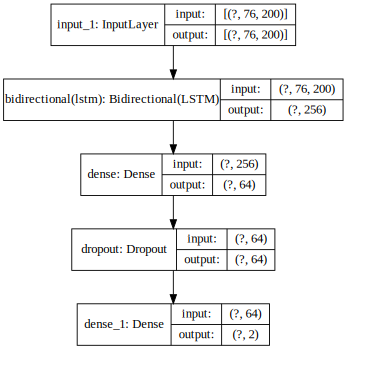

In [17]:
# SVG로 시각화 해볼게요.
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [18]:
# summary()로 확인해볼게요.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 353,474
Trainable params: 353,474
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 모델 학습 진행할게요.
# 많이 오래 걸려요.
# 이번주 진행했던 코드들 복습해주세요.
model.fit(x_train, y_train, epochs=10, batch_size=128, callbacks=[history])

Epoch 1/10
403/403 [==============================] - 66s 164ms/step - loss: 0.5587 - accuracy: 0.7055
Epoch 2/10
403/403 [==============================] - 68s 169ms/step - loss: 0.4858 - accuracy: 0.7579
Epoch 3/10
403/403 [==============================] - 66s 164ms/step - loss: 0.4472 - accuracy: 0.7830
Epoch 4/10
403/403 [==============================] - 65s 162ms/step - loss: 0.4060 - accuracy: 0.8086
Epoch 5/10
403/403 [==============================] - 65s 162ms/step - loss: 0.3623 - accuracy: 0.8303
Epoch 6/10
403/403 [==============================] - 68s 170ms/step - loss: 0.3213 - accuracy: 0.8517
Epoch 7/10
403/403 [==============================] - 66s 164ms/step - loss: 0.2781 - accuracy: 0.8739
Epoch 8/10
403/403 [==============================] - 68s 168ms/step - loss: 0.2394 - accuracy: 0.8915
Epoch 9/10
403/403 [==============================] - 66s 163ms/step - loss: 0.2092 - accuracy: 0.9058
Epoch 10/10
403/403 [==============================] - 65s 162ms/step - l

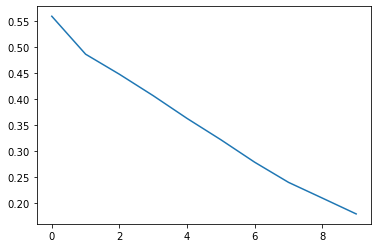

In [20]:
# Loss 확인할게요.
loss = history.losses
epochs = range(len(loss))
plt.plot(epochs, loss)
plt.show()

In [21]:
# 모델의 정확도만 평가하는 함수작성 할게요.
def _eval(sentences, labels):
    correct_cnt = 0
    
    # 문장이랑 레이블 받아서 진행할게요.
    for sentence, label in zip(sentences, labels):
        # 모델 입력 데이터 array로 바꾸면서, 타입도 변경할게요.
        x = np.asarray(sentence).astype('float')
        
        # RNN 계열은 입력이 3차원이기 때문에 shape 변경할게요.
        x = x.reshape(1, x.shape[0], x.shape[1])
        
        # label은 (0, 1)로 되어있으니까, max값의 인덱스로
        # label 설정할게요.
        y = list(label)
        y = y.index(max(y))
        
        # 모델로 x 분류 진행할게요.
        predict = np.squeeze(model.predict(x))
        predict = predict.argmax()
        if predict == y:
            correct_cnt += 1
    return correct_cnt

In [22]:
# 모델에 학습 데이터로 모델 정확도 확인할게요.
# 조금 많이 오래걸려요. 
# 이번주 진행했던 코드들 복습해주세요.
ccnt = _eval(x_train, y_train)
print(ccnt, ' / ', len(x_train),' : ', ccnt/len(x_train))

48283  /  51562  :  0.9364066560645437


In [23]:
# 평가 데이터로 모델 정확도 확인할게요.
# 조금 많이 오래걸려요.
# 이번주 진행했던 코드들 복습해주세요.
ccnt = _eval(x_test, y_test)
print(ccnt, ' / ', len(x_test), ' : ' , ccnt/len(x_test))

16431  /  22201  :  0.7401017972163416


### 다 되셨으면, 어제 사용했던 ChatbotData로 레이블 3개인 멀티클래스 분류를 진행해보세요. ###


**-1. 먼저 데이터 읽어주세요. 컬럼은 'Q'랑 'label'만 사용할게요.**  

**-2. 읽은 데이터를 DataFrame으로 만들어 주세요.**

**-3. DataFrame를 레이블로 그룹화 해주세요.**  

**-4. 그룹화된 DataFrame에서 각 레이블 그룹별로 학습에 7, 평가에 3으로 나눠주세요.**  

**-5. 학습문장, 평가문장 각각 읽어가며, 토크나이즈해서 words_set 만들면서, 최대 문장 길이인 max_len 설정해주세요.**  

**-6. 학습문장, 평가문장 각각 모델의 입력과 출력을 위한 형태로 만들어주세요.  
      모델에 임베딩 레이어 추가하셔도 되고, 아니면 word2vec pre-trained 모델 사용하셔도 되요.  
      모델의 입력은 shape=(문장 개수, max_len, embedding_size)이고, 출력은 shape=(문장 개수, label 개수) 에요.**
      
**-7. 모델은 만드시고 싶으신데로 만들어주세요. CNN을 사용해도 상관없어요.**

**-8. SVG()사용해서 모델 시각화 해주세요.**

**-9. 모델 컴파일 하시고, 학습 진행해주세요.**

**-10. 마지막으로, 평가 데이터로 모델 평가 진행해주세요.**